In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

input_img = 'sample_viirs/jan921.tiff'
output_img = 'sample_viirs/sample.tiff'

# img = cv.imread('Sample VIIRS/jan721.tiff')
img = cv.imread(input_img)

M = 512
N = M

if os.path.exists("prediction_inputs"):
    os.system("rm -r prediction_inputs/")
os.mkdir("prediction_inputs")
os.mkdir("prediction_inputs/cloudy_image")


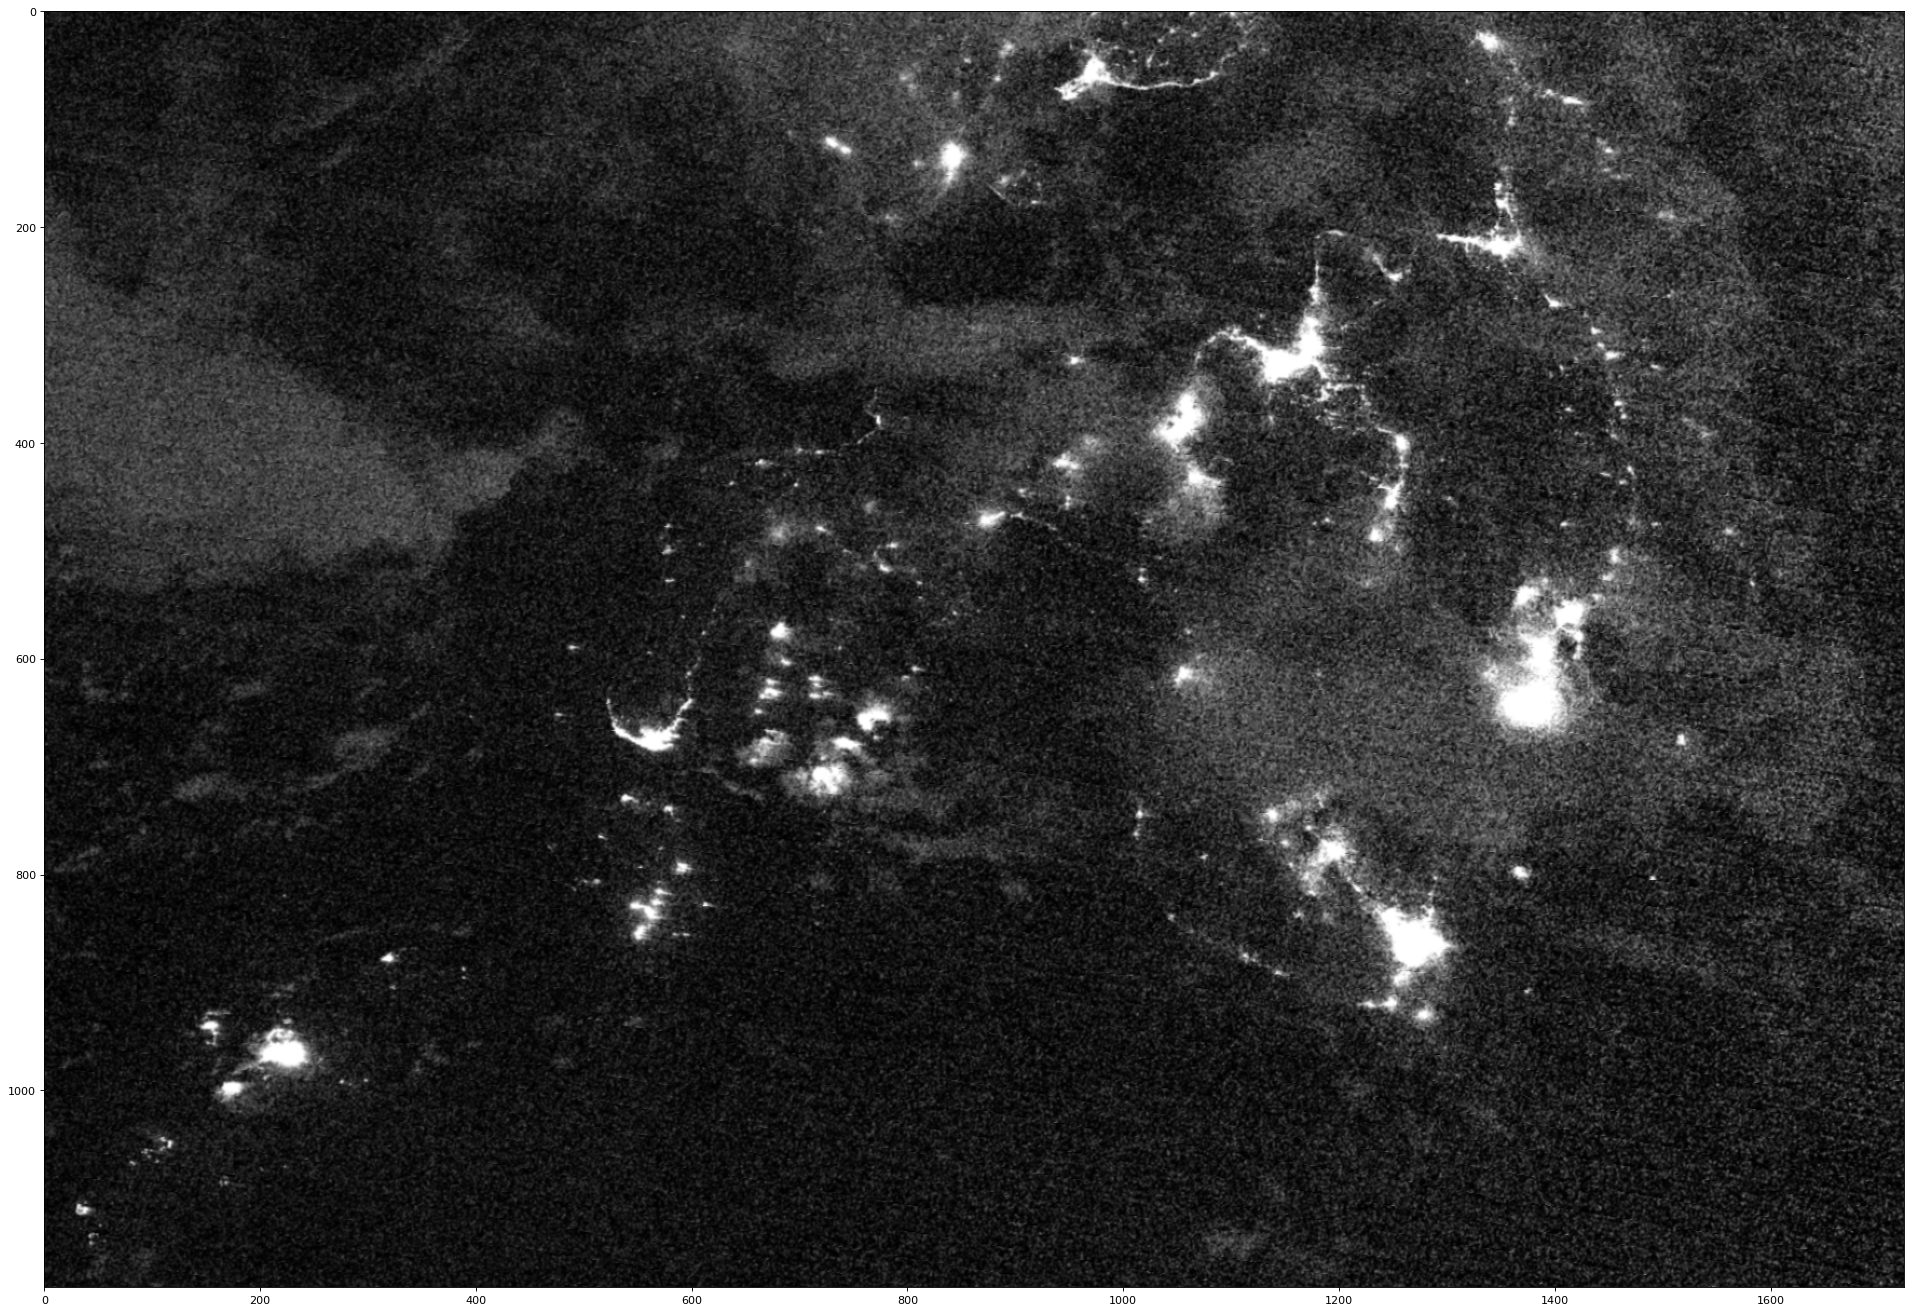

In [8]:
fig = plt.figure(figsize=(30, 30),dpi=80) 
plt.imshow(img)

In [7]:
i = 0
arr = []
print("ORIGINAL ", img.shape)

# slicing images into 512 x 512, with iteration moving at 512/4
for x in range(0,img.shape[0] // M + 2):
    for y in range(0,img.shape[1] // N + 2):
        x1 = x * M if x * M < img.shape[0] and x * M + M < img.shape[0] else img.shape[0]- M
        y1 = y * N if y * N < img.shape[1] and y * N + N < img.shape[1] else img.shape[1] - N
        # getting the image slice
        sampimg = img[x1:x1+M,y1:y1+N]
        # recording image name, and location where it will be placed in the new image
        arr.append([str(i)+".tiff", x1, x1+M, y1, y1+N])
        # writing it into the prediction directory
        cv.imwrite(os.path.join("prediction_inputs/cloudy_image", arr[i][0]), sampimg)
        i += 1

ORIGINAL  (1183, 1724, 3)


In [8]:
"""
Python prediction script. Use based on whether you have a GPU or not
"""

# w/o GPU
# os.system("python predict_general.py --config pretrained_models/Denoised/config_cpu.yml --pretrained pretrained_models/Denoised/gen_model_epoch_60.pth ")

# w/ GPU
os.system("python predict_general.py --config pretrained_models/Denoised/config_gpu.yml --pretrained pretrained_models/Denoised/gen_model_epoch_60.pth  --cuda")

Random Seed:  0
===> Loading models


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


7.tiff
18.tiff
8.tiff
11.tiff
15.tiff
6.tiff
14.tiff
12.tiff
10.tiff
4.tiff
3.tiff
19.tiff
17.tiff
9.tiff
1.tiff
0.tiff
2.tiff
16.tiff
13.tiff
5.tiff


0

In [9]:
# base arrays for reconstructing image
new_img = np.zeros(img.shape)
attentionmap = np.zeros(img.shape)

# getting the 2nd part of the three images
# recall: 1st image - cloudy, 2nd image - cleaned, 3rd image - attention map
for item in arr:
    val = cv.imread(os.path.join("prediction_inputs/epoch_0001", item[0]))
    h, w, channels = val.shape
    trio = w//3
    cleaned = val[:, 1*trio:2*trio] 
    # adding the image based on its stored position
    img[item[1]:item[2], item[3]:item[4]] = cleaned
    attentionmap[item[1]:item[2], item[3]:item[4]] = val[:, 2*trio:]

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fd68c309c70>)

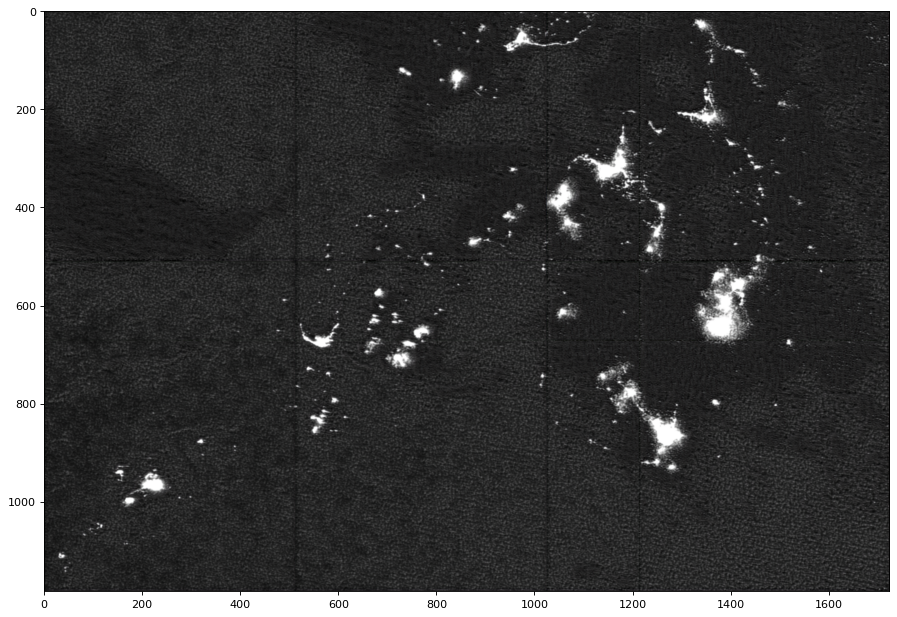

In [10]:
fig = plt.figure(figsize=(30, 30),dpi=80) 
plt.subplot(121), plt.imshow(img) # original image
# plt.subplot(122); plt.imshow(new_img.astype("uint8")) # cleaned/newly reconstructed image

In [6]:
# plt.imshow(attentionmap.astype("uint8"))

In [9]:
cv.imwrite(output_img, img)

True